In [1]:
import copy
import io
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox
from IPython.display import display
import json
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
import spacy
from tqdm.notebook import trange, tqdm

In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
def load_vectors_pd(fname, total_to_load=10000):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    index = []
    total_loaded = 0
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
        total_loaded += 1
        if total_loaded >= total_to_load:
            break
    return pd.DataFrame(data)

In [4]:
DATA_PATH = "../data/"

In [5]:
# type in codenames here

red_codenames = ['pit', 'newton', 'elephant', 'sub', 'street', 'model', 'lemon', 'lock']
blue_codenames = ['judge', 'paddle', 'volcano', 'bed', 'break', 'driver', 'ram', 'hotel']
beige_codenames = ['snow', 'tattoo', 'guitar', 'paint', 'trick', 'walrus', 'hook']
black_codenames = ["squirrel"]

red_codenames = ['fog', 'tornado', 'poison', 'purse', 'night', 'brush', 'aztec', 'blade']
blue_codenames = ['crab', 'balloon', 'diamond', 'file', 'state', 'ruler', 'sound', 'dollar', 'drum']
beige_codenames = ['shower', 'tea', 'university', 'bomb', 'leather', 'cover', 'tattoo']
black_codenames = ['mouse']

In [6]:
all_codenames = red_codenames + blue_codenames + beige_codenames + black_codenames

In [7]:
codenames_to_lemmas = {}
for codename in all_codenames:
    doc = nlp(codename)
    for token in doc:
        codenames_to_lemmas[codename] = token.lemma_
        
for codename_set in [blue_codenames, red_codenames, beige_codenames, black_codenames]:
    for i in range(len(codename_set)):
        codename_set[i] = codenames_to_lemmas[codename_set[i]]

In [8]:
vectors = load_vectors_pd(DATA_PATH + "crawl-300d-2M.vec", 200000)

In [9]:
vector_word_to_lemma_path = DATA_PATH + "/vector_word_to_lemma_v2.json"
with open(vector_word_to_lemma_path, "r") as f:
    vector_word_to_lemma = json.load(f)
# vector_word_to_lemma = dict()

for i in trange(vectors.shape[1]):
    word = vectors.columns[i]
    if word not in vector_word_to_lemma:
        doc = nlp(word)
        for token in doc:
            vector_word_to_lemma[word] = token.lemma_
            # there is punctuation that must be removed signs and such
            break

with open(vector_word_to_lemma_path, "w") as f:
    json.dump(vector_word_to_lemma, f)

  0%|          | 0/200000 [00:00<?, ?it/s]

In [10]:
# distinct words in vocabulary versus total words
print(len(vector_word_to_lemma.keys()))
print(len(set(vector_word_to_lemma.values())))

200000
124348


In [11]:
lemmas = set([vector_word_to_lemma[word] for word in vectors.columns])
for codename in all_codenames:
    assert(codename in lemmas)

In [12]:
def compare_codename_to_word(codename, word):
    lower_word = word.lower()
    lower_lemma = vector_word_to_lemma[word].lower()
    return codename not in lower_lemma and lower_lemma not in codename and codename not in lower_word and lower_word not in codename
compare_codename_to_word("model", "Modes")

def transform_cos_distance(cos_distance, a, b):
    return np.exp(a - b * cos_distance) / (1 + np.exp(a - b * cos_distance))

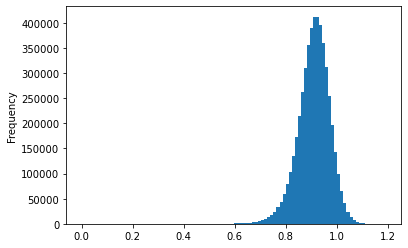

In [13]:
all_cos_distances = pd.DataFrame(cosine_distances(vectors[all_codenames].transpose(), vectors.transpose()), index=all_codenames, columns=vectors.columns)
pd.Series(all_cos_distances.values.flatten()).plot(kind="hist", bins=100)
cos_stacked_distances = all_cos_distances.stack()
all_prob_from_cosine = transform_cos_distance(all_cos_distances, a=12, b=16)

In [14]:
words_to_keep = []
for word in all_prob_from_cosine.columns:
    keep_word = True
    for codename in all_prob_from_cosine.index:
        if compare_codename_to_word(codename, word) is False:
            keep_word = False
    if keep_word:
        words_to_keep.append(word)

In [15]:
def colors_from_codenames(s):
    colors = []
    for idx in s.index:
        if idx in red_codenames:
            colors.append('background-color: lightcoral')
        if idx in blue_codenames:
            colors.append('background-color: cornflowerblue')
        if idx in beige_codenames:
            colors.append('background-color: bisque')
        if idx in black_codenames:
            colors.append('background-color: dimgray')
    return colors

In [16]:
def utility_function(probs, red_codenames, blue_codenames, beige_codenames, black_codenames, team="red"):
    # We should actually simulate the process of drawing these codenames
    # it's very bad to draw the assassin, so let's try to stay away from him at all costs
    black_util = all_prob_from_cosine.loc[black_codenames, :].sum(axis=0) * -15
    # it's not really that bad to draw a beige tile, but it might stop you from finding the right tile
    opportunity_cost = -0.04
    beige_util = all_prob_from_cosine.loc[beige_codenames, :].sum(axis=0) * opportunity_cost
    red_util = all_prob_from_cosine.loc[red_codenames, :].sum(axis=0)
    blue_util = all_prob_from_cosine.loc[blue_codenames, :].sum(axis=0)
    if team == "red":
        blue_util = -1 * blue_util + opportunity_cost
    if team == "blue":
        red_util = -1 * red_util + opportunity_cost
    if team != "red" and team != "blue":
        return Exception
    return black_util + beige_util + red_util + blue_util

In [17]:
def display_candidate_clues(team, **kwargs):
    assert team in {"red", "blue"}
    # 9, 14 was pretty good
    def filt_codenames(codenames):
        return [codename for codename in codenames if kwargs[codename]]
    utility_by_word = utility_function(all_prob_from_cosine,
                                       red_codenames=filt_codenames(red_codenames),
                                       blue_codenames=filt_codenames(blue_codenames),
                                       beige_codenames=filt_codenames(beige_codenames),
                                       black_codenames=filt_codenames(black_codenames),
                                       team=team)
    codenames_to_display = filt_codenames(all_codenames)
    candidate_words = utility_by_word[words_to_keep].sort_values().tail(48).index
    candidate_probs = all_prob_from_cosine[candidate_words]
    for i in np.arange(0, len(candidate_words), 16):
        display(candidate_probs.loc[codenames_to_display].iloc[:, i:(i + 16)].style.apply(colors_from_codenames, axis=0))

In [18]:
checkboxes_dict = dict((codename, widgets.Checkbox(True, description=codename))  for codename in all_codenames)
# _ = widgets.interact(display_candidate_clues, team="blue", **checkboxes_dict)

In [19]:
interactive = widgets.interactive(display_candidate_clues, team=["blue", "red"], **checkboxes_dict)

In [29]:
interactive.children[0]

Dropdown(description='team', index=1, options=('blue', 'red'), value='red')

In [28]:
boxes = []
for codenames in [red_codenames, blue_codenames, beige_codenames, black_codenames]:
    box = [checkboxes_dict[codename] for codename in codenames]
    boxes.append(VBox(box))
HBox(boxes)

In [24]:
interactive.children[-1]

Output()

# Scratchwork

In [19]:
# _ = widgets.interact(display_candidate_clues, team=team, **{codename: widgets.fixed(True) for codename in all_codenames})

NameError: name 'team' is not defined

In [83]:
# import ipywidgets as widgets

# box = widgets.Checkbox(False, description='checker')
# out = widgets.Output()

# @out.capture()
# def changed(b):
#     b["
#     print(b)

# box.observe(changed)

# display(box)
# display(out)

In [ ]:
# global codenames_selected
# codenames_selected = copy.deepcopy(all_codenames)

In [ ]:
# # add this in later
# team = widgets.Dropdown(
#     options=["blue", "red"],
#     value="blue"
# )
# display(team)

In [186]:
# _ = widgets.interact(display_candidate_clues, team=team, **{codename: widgets.fixed(True) for codename in all_codenames})

In [ ]:
checkboxes_dict = dict((codename, widgets.Checkbox(True, description=codename))  for codename in all_codenames)

In [139]:


# left_box = VBox([items[0], items[1]])
# right_box = VBox([items[2], items[3]])
# boxes = []
# current_idx = 0
# for i in range(5):
#     box = []
#     for j in range(5):
        
#     boxes.append(Vbox([]))
# HBox([left_box, right_box])

In [ ]:
_ = widgets.interact(display_candidate_clues, team=team, **checkboxes_dict)

In [188]:
# interactive.children[-1]

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<pandas.io.formats.style.Styler at 0x7…

In [175]:
interactive = widgets.interactive(display_candidate_clues, team=team, **checkboxes_dict)
display(interactive.children[15])


Checkbox(value=True, description='sound')

In [106]:
# def display_candidate_clues(team, **kwargs):
#     assert team in {"red", "blue"}
#     # 9, 14 was pretty good
#     def filt_codenames(codenames):
#         return [codename for codename in codenames if codename in codenames_selected]
#     utility_by_word = utility_function(all_prob_from_cosine,
#                                        filt_codenames(red_codenames),
#                                        filt_codenames(blue_codenames),
#                                        filt_codenames(beige_codenames),
#                                        filt_codenames(black_codenames), team=team)
#     # utility_by_word[words_to_keep].sort_values().tail(40)
#     candidate_words = utility_by_word[words_to_keep].sort_values().tail(40).index
#     candidate_probs = all_prob_from_cosine[candidate_words]
#     display(candidate_probs.style.apply(colors_from_codenames, axis=0))

In [128]:
checkboxes_dict = dict((codename, widgets.Checkbox(True, description=codename))  for codename in all_codenames)

In [137]:
# widgets.interact(display_candidate_clues, 
#                 c1=checkboxes[0], c2=checkboxes[1]) 

In [189]:
# checkboxes = [widgets.Checkbox(True, description=codename) for codename in all_codenames]
# out = widgets.Output()

# @out.capture()
# def changed(b):
#     if b["name"] == "value":
#         description = b["owner"].description
#         if b.new == False:
#             codenames_selected.remove(description)
#         if b.new == True:
#             codenames_selected.add(description)
#         display_candidate_clues()
    
# for checkbox in checkboxes:
#     checkbox.observe(changed)
#     display(checkbox)

# display(out)

    


# Calibrating Cosine Distance to Probability Transform

In [84]:
display()

<function IPython.core.display.display(*objs, include=None, exclude=None, metadata=None, transient=None, display_id=None, **kwargs)>

In [ ]:
# looking at cosine distances between words

viz_similarities = list()
prev_value = 0
for cur_value in np.linspace(0, 1, 200):
    distances = cos_stacked_distances[np.logical_and(cos_stacked_distances > prev_value, cos_stacked_distances < cur_value).values]
    diff_lemma_distances = distances[[compare_codename_to_word(idx[0], idx[1]) for idx in distances.index]]
    if diff_lemma_distances.shape[0] >= 1:
        viz_distances = diff_lemma_distances.sample(1)
        viz_similarities.append((prev_value, cur_value, viz_distances.index[0][0], viz_distances.index[0][1], viz_distances.values[0]))
    prev_value = cur_value

In [ ]:
pd_viz_sim = pd.DataFrame(viz_similarities, columns=["begin_bucket", "end_bucket", "codename", "word", "cos_dist"])
pd_viz_sim["prob"] = transform_cos_distance(pd_viz_sim["cos_dist"], a=14, b=22)

for _, row in pd_viz_sim[["cos_dist", "prob", "codename", "word"]].iterrows():
    print(row.values)

In [ ]:
x = np.linspace(0, 1, 500)
y = transform_cos_distance(x, a=12, b=16)
pd.DataFrame({"x": x, "y": y}).plot(x="x", y="y", kind="line")